# HW3 - Part1, CMPE 252, Section 01, SPRING 2023


## Topic: Sequential Decision Making in the tabular case. 
In this question you will solve MDP by **Value Iteration** and **Policy Iteration**
algorithms with a known dynamics and reward, $T$ and $R$, respectively. 

You can work in teams, and discuss your solutions, but not to share your code with other teams.

What to submit in Canvas: 1) a working notebook with the full solution, and 2) its corresponding PDF. 


Due date : April 7, 11:59PM



import the necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline


Define the variables needed for the Tasks

In [ ]:
max_it = 100

# Set DEF_Qx to True to solve for Task x
DEF_Q3 = True
DEF_Q5_1 = True
DEF_Q5_2 = True
DEF_Q6 = True
DEF_Q7 = True

# For Task 5, define an arbitrary point in the middle of the maze
ss = (5,5) #'???' # eg: ss = (5,5)
V_ss = []
V_ss1 = []
V_ss2 = []

In [ ]:
# For Task 6, define a norm function
def norm(m):
    sum = 0
    for _, val in np.ndenumerate(m):
        sum += val*val
    return np.sqrt(sum)
        

In [ ]:
def build_maze(maze_file):
    '''
    para1: filename of the maze txt file
    return mazes as a numpy array walls: 0 - no wall, 1 - wall
    '''
    a = open(maze_file, 'r')  
    m=[]
    for i in a.readlines():
        m.append(np.array(i.split(" "), dtype="int32"))
    return np.array(m)

#### Create a maze file with 0 - no wall, 1 - wall. Verify that there are multiple paths (at least 3) from the START = 'top left corner' to GOAL='bottom right corner'. If you do not have at least 3 paths, update your maze accordingly

In [ ]:
# State Space
S=build_maze("maze_20x20.txt")
START = (1,1)
GOAL = (19,19)
# Action Space
A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]


# Noise
ALPHA = [0.2, 0.8]

In [ ]:
GRID_SIZE = len(S)
# goal state
S[GOAL]    = 3

Visualize the maze

In [ ]:
print(S)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1]
 [1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1]
 [1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1]
 [1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1]
 [1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1]
 [1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1]
 [1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1]
 [1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1]
 [1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1]
 [1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1]
 [1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1]
 [1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


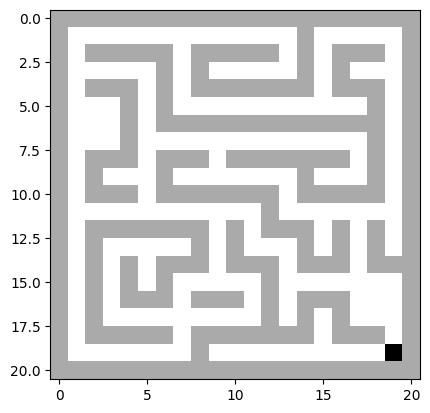

In [ ]:
plt.imshow(S, cmap='binary')

We will define a utility function s_next_calc which computes the index of the next state given current state and action.

In [ ]:
def s_next_calc(s, a):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: action taken by the agent
    : returns: New state coordinates in the grid
    '''
    
    return (s[0] + A[a][0], s[1] + A[a][1])

A Utility function to check if the action at current state leads to a collision with a wall.

In [ ]:
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls.
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    s_new = (
        curr[0] + A[action][0],
        curr[1] + A[action][1]
    )

    # Check for grid boundaries
    if min(s_new) < 0 or max(s_new) > GRID_SIZE-1:
        return True

    # Check walls
    # 0: 'up':   (-1,  0),
    # 1: 'down': ( 1,  0),
    # 2: 'left': ( 0, -1),
    # 3: 'right':( 0,  1),
    # 4: 'stay': ( 0,  0)
    if (S[curr]==0 and S[s_new]==1):
        return True

    return False

Reward function.

In [ ]:
def R(s, a):
    '''Reward function
    : param s: Current state of the agent
    : param a: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return 0
    elif hit_wall(s, a):
        return -10000
    else:
        return -1

Calculate the transition probabilities to state s_next from current state s upon action a.

In [ ]:
def Pr(s_next, s, a, alpha):
    '''This function returns probabilities for each action at agent's
    current state.
    :param s: Current state of the agent
    :param a: Action the agent takes at the current state
    :param alpha: Probability of the agent to take a random action instead of the action a
    :returns : Transition probability for the action at current state
    '''
    # can't move once reached the GOAL
    if s == GOAL:
        if s_next == s:
            return 1
        else:
            return 0

    # If wall hit, next state is current state
    if hit_wall(s, a):
        # Illegal action with s = s'
        if s_next == s:
            return 1
        # Illegal action with s != s'
        else:
            return 0

    # Legal action with adjacent s and s'
    if s_next == s_next_calc(s, a):
        return 1 - alpha
    else:
        # Agent moves to another adjacent state instead of s' due to noise in a
        # Generate all other neighbors of s by applying actions other than a
        other_s_next = [s_next_calc(s, i)
                    for i in range(len(A)) if i is not a]
        if s_next in other_s_next:
            return alpha/4
    return 0

In [ ]:
def calc_sigma(s, a, alpha, V):

  valid  = lambda x : 0 <= x[0] < GRID_SIZE and 0 <= x[1] < GRID_SIZE

  sigma = 0
  for i in range(len(A)):
    s_next = s_next_calc(s, i)
    if valid(s_next) : sigma += Pr(s_next, s, a, alpha) * V[s_next]

  return sigma


## Policy Iteration

In policy iteration, we define three functions:

* policy_evaluation
* policy_improvement
* policy_iteration

Refer to the lecture slides on policy iteration and value iteration. 

In [ ]:
def policy_evaluation(policy, S, Pr, alpha, discount, theta, ctr):
    
    V = np.zeros((GRID_SIZE, GRID_SIZE))
    V_prev = np.zeros((GRID_SIZE, GRID_SIZE))
    
    global V_ss # For Task 5
    V_ss.clear() # For Task 5

    for i in range(ctr):
        # chose an initial delta value for the convergence test (see lines 14 and 16 below) 
        delta =  0 #'???'
        V_prev = V.copy()
        for s, _ in np.ndenumerate(S):
                 
            # action by the policy
            a = policy[s] #'???'
            
            # update value function for the state s  
            V[s] = R(s, a) + discount * calc_sigma(s, a, alpha, V_prev)  #'???' <<<>>> 

            #print(s, delta, V[s], V_prev[s])

            # convergece test  
            delta = max(delta, abs(V[s] - V_prev[s]))
            
            if(DEF_Q5_1 == True): # For Task 5
                if(s == ss):
                    V_ss.append(V[s]) 

        #print(i, delta)
        if delta < theta: break
    #print(delta)

    return V, delta
   
   

In [ ]:
def policy_improvement(V, S, A, Pr, alpha, discount):
    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    policy_stable = True
    
    global V_ss2 # For Task 5
        
    for s, _ in np.ndenumerate(S):
              
        old_action = policy[s]
        Q = np.zeros(len(A))
        for a in range(len(A)):
            # update Q function at state, s, and action, a
            Q[a] = R(s, a) + discount * calc_sigma(s, a, alpha, V) #'???' <<<>>>
            # update policy at state s
            policy[s] = np.argmax(Q) #'???'
            
        if(DEF_Q5_2 == True): # For Task 5
            if (s == ss):
                V_ss2.append(max(Q)) 
            
        if old_action != policy[s]: policy_stable = False
    
    return policy, policy_stable

In [ ]:
def policy_iteration(S, A, Pr, alpha, discount, theta, n_eval, plot_enable, plot=None):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: discount factor
    :param int n_iter: number of iterations
    :param int n_eval: number of evaluations
    :param plot: list of iteration numbers to plot
    """
    
    epsilon = 0
    
    # For Task 4
    start_time = 0
    end_time = 0
    time = 0
    total_time = 0
    
    # For Task 5
    global V_ss
    global V_ss1
    global V_ss2
    V_ss.clear()
    V_ss1.clear()
    V_ss2.clear()
    
    normV = [] # For Task 6
    V_prev = np.zeros((GRID_SIZE, GRID_SIZE)) # For Task 6
    deltaV = [] # For Task 7
    
    plt.ion()
    policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE))
    count=0
    

    while True:
                
        if(DEF_Q5_1 == True): # For Task 5
            if(count == 10): # The iteration number of the 'policy improvement' is taken as 10. Feel free to change it.
                V_ss1 = V_ss.copy()
        
        if DEF_Q3 == True: # For Task 3
            start_time = datetime.datetime.now()
        
        #print("This is policy_iteration")
        

        V, delta = policy_evaluation(policy, S, Pr, alpha, discount, theta, n_eval)
        policy , policy_stable = policy_improvement(V, S, A, Pr, alpha, discount)
        #print("Moose", delta)

        
        if DEF_Q3 == True: # For Task 3
            end_time = datetime.datetime.now()
            time = (end_time - start_time).total_seconds() # calculate time taken [seconds] for one iteration
            total_time += time
      
        if DEF_Q6 == True: # For Task 6
            normV.append(norm(V - V_prev))
            V_prev = V.copy()
            
        if DEF_Q7 == True: # For Task 7
            deltaV.append(delta)
            
        
        # plot intermediate result
        if (plot and count+1 in plot) and plot_enable:
            plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
        
        if delta == 0:
            if plot_enable :
                plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            break
                
        if (delta > 0 and delta<=epsilon) or count==max_it or policy_stable:    
            if(count == max_it):
                print('Policy iteration failed to converge for alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            if(plot_enable):
                 plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            break
        count=count+1

    return V, policy, count, total_time, normV, deltaV


## Value Iteration

We use the following function for value iteration. See slides starting from 161.

In [ ]:
def value_iteration(S, A, Pr, alpha, discount, plot_enable, plot=None):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: noise parameter
    """
    # For Task 4
    start_time = 0
    end_time = 0
    time = 0
    total_time = 0
    
    normV = [] # For Task 6
     
    plt.ion()

    V = np.zeros((GRID_SIZE, GRID_SIZE))
    V_prev = np.zeros((GRID_SIZE, GRID_SIZE))
    optimal_policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE), dtype=int)

    count=0
    while True:
        
        if DEF_Q3 == True: # For Task 3
            start_time = datetime.datetime.now()
    
        delta = 0 
        V_prev = V.copy()
        
        for s,_ in np.ndenumerate(S):
            Q = np.zeros(len(A))
            for a in range(len(A)):
                Q[a] = R(s, a) + discount * calc_sigma(s, a, alpha, V) #'???' <<<>>> # expression for the Q function at state, s, and action, a
            V[s] = np.max(Q) #'???'
            delta = max(delta, abs(V[s] - V_prev[s])) # '???' # set the validation condition for the convergence
            #print(delta)
            
            optimal_policy[s] = np.argmax(Q)
        
        if DEF_Q3 == True: # For Task 3
            end_time = datetime.datetime.now()
            time = (end_time - start_time).total_seconds() # calculate time taken [seconds] for one iteration
            total_time += time
        
        if DEF_Q6 == True: # For Task 6
            normV.append(norm(V - V_prev))

        # plot current value and optimal policy
        if (plot and count+1 in plot) and plot_enable:
            plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            plt.pause(0.1)
        if delta <= 0 or count==max_it: 
            if count == max_it:
                print('Value iteration failed to converge for alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            if(plot_enable):
                plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
                plt.pause(0.1)
            break
        count=count+1
    return V, optimal_policy, count, total_time, normV


We will use the following utility function to plot the grid with values from V.

In [ ]:
def plot_value_grid(V, policy, msg=""):
    fig = plt.figure(figsize=(5, 5), tight_layout=True)
    plt.title(msg)
    plt.imshow(V)
   
    quiver_action_dict = [
            [1, 0],
            [-1, 0],
            [0, -1],
            [0, 1],
            [0, 0]
    ]
    for k, a in np.ndenumerate(policy):
        if(S[k] == 0): # do not print the arrows on walls, to increase readibility
            q = plt.quiver(k[1], k[0], quiver_action_dict[a][1], quiver_action_dict[a][0])
    #fig.colorbar(q)
    plt.show()

## Tasks
### A. Find the optimal solution by two methods for $\alpha$ = 0.

### I. Policy Iteration 

We are using iterative policy evaluation.

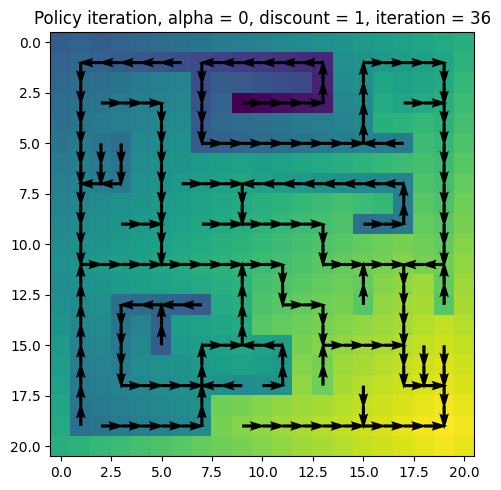

In [ ]:
n_pol_eval = 100 #number of policy evalutions
val2, pol2, pol_max_iter, time_taken, normV, deltaV = policy_iteration(S, A, Pr, alpha=0, discount=1, theta = 1e-6, n_eval=n_pol_eval, plot_enable = True)


### II. Value Iteration

Run for 100 iterations and no noise
Plot the value function and the optimal policy every 20 iterations

/usr/local/lib/python3.9/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.9/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


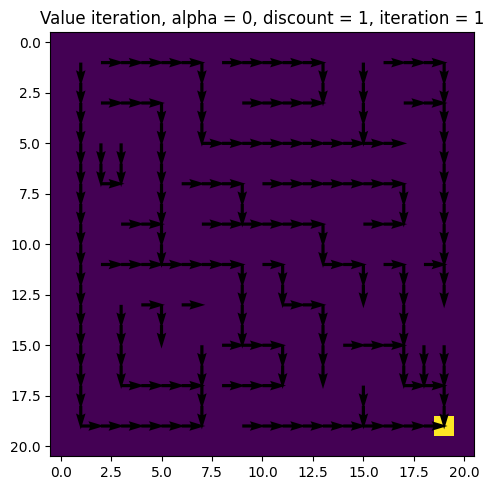

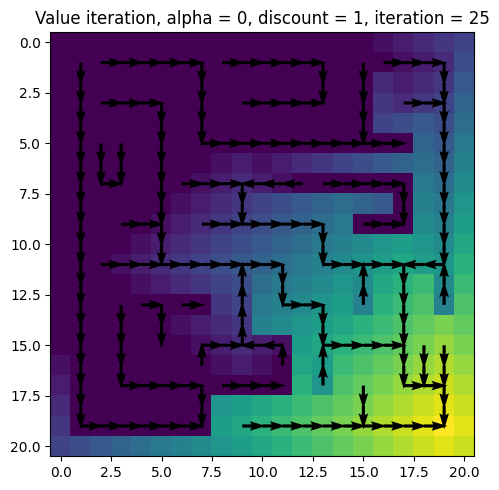

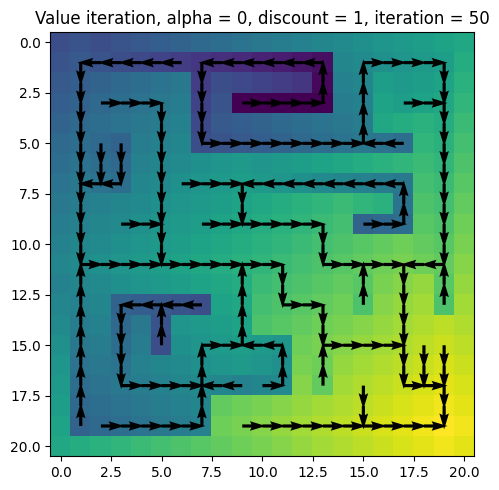

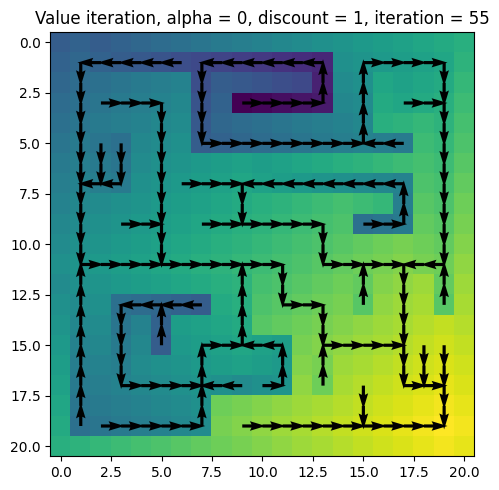

In [ ]:
val1, pol1, val_max_iter, time_taken, normV = value_iteration(S, A, Pr, alpha=0, discount=1, plot_enable=True, plot=[1, 25, 50, 100])


Let's visualize these results

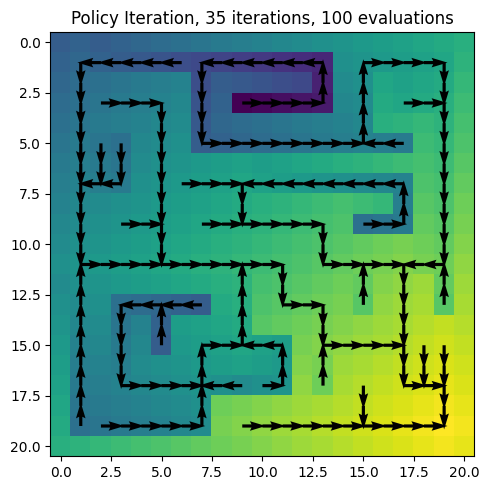

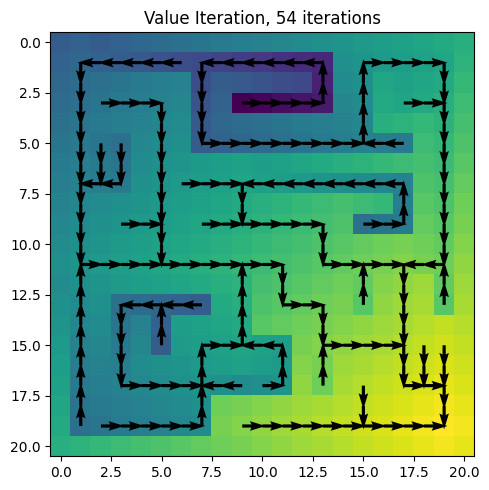

In [ ]:
# Plot for policy iteration alpha = 0, k_max = 100, run for 100 iterations
plot_value_grid(val2, pol2, msg='Policy Iteration, {} iterations, {} evaluations'.format(pol_max_iter, n_pol_eval))
# Plot for value iteration alpha = 0, 100 iterations
plot_value_grid(val1, pol1, msg='Value Iteration, {} iterations'.format(val_max_iter))

### III. Run Policy Iteration and Value Iteration for  five different discounted factors $\gamma \in \{0, 0.1, 0.4, 0.9, 1\}$ and perform the following tasks

1. Explain the change in utilities for different $\gamma$
2. Explain the change in optimal policies for different $\gamma$

#### Policy iteration for 𝛾∈{0,0.1,0.4,0.9,1} :

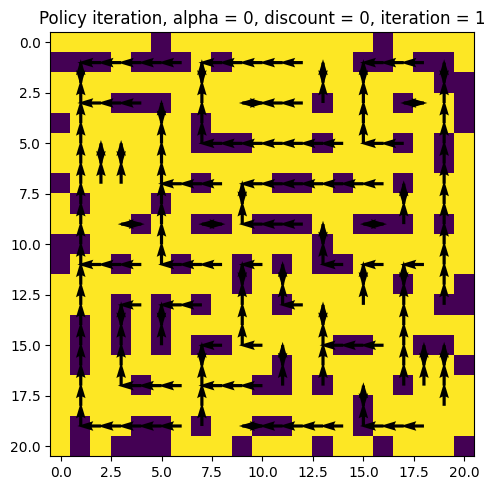

Policy iteration failed to converge for alpha = 0, discount = 0.1, iteration = 101


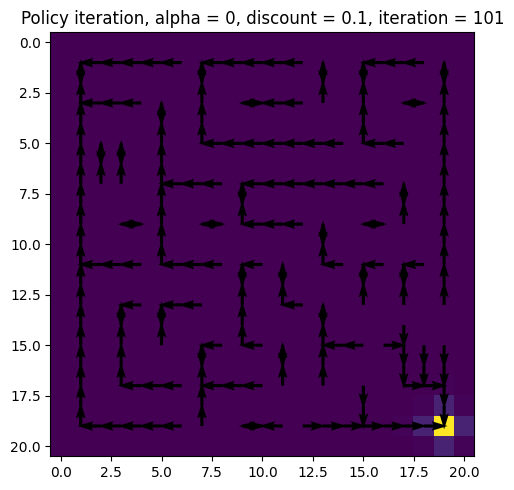

Policy iteration failed to converge for alpha = 0, discount = 0.4, iteration = 101


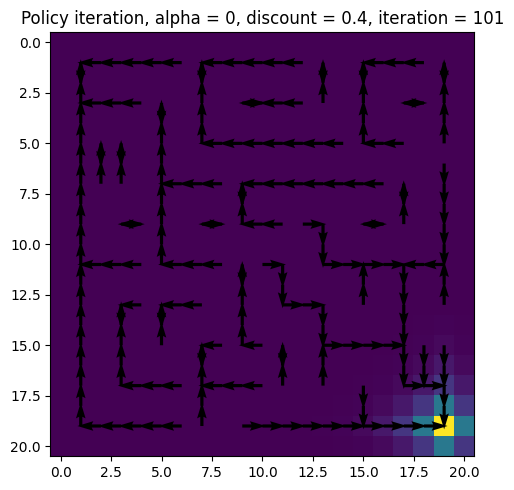

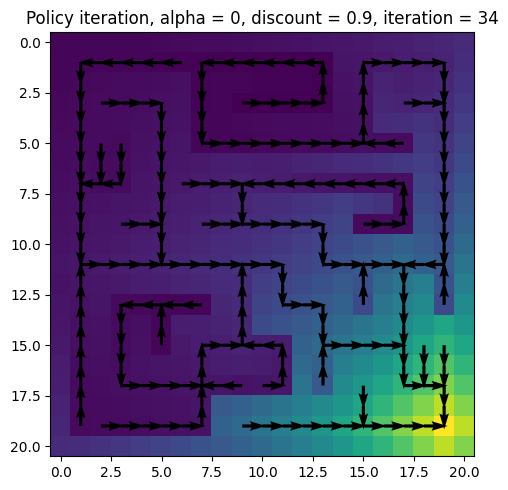

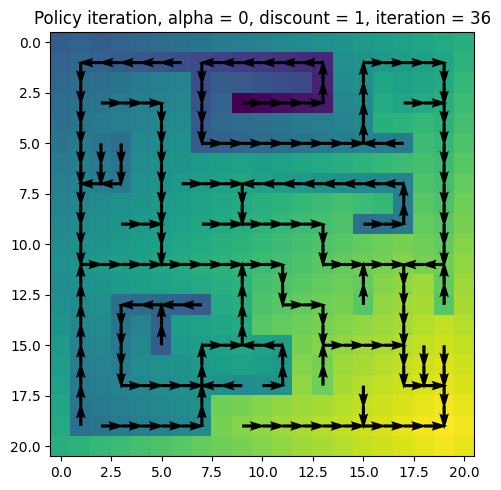

In [ ]:
DEF_Q3 = True
n_pol_eval = 100 #number of policy evalutions
pol_time_list = []
for gamma in [0,0.1,0.4,0.9,1] :  
    val2, pol2, pol_max_iter, comp_time, normV, deltaV = policy_iteration(S, A, Pr, alpha=0, discount=gamma, theta=1e-6, n_eval=n_pol_eval, plot_enable = True)
    pol_time_list.append(comp_time)
    plt.pause(0.1)
DEF_Q3 = False

#### Value iteration for 𝛾∈{0,0.1,0.4,0.9,1} :

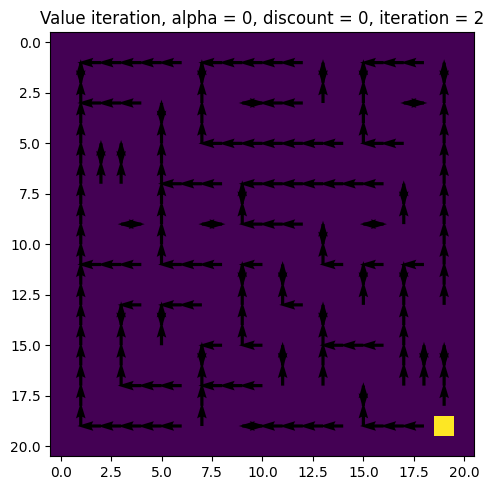

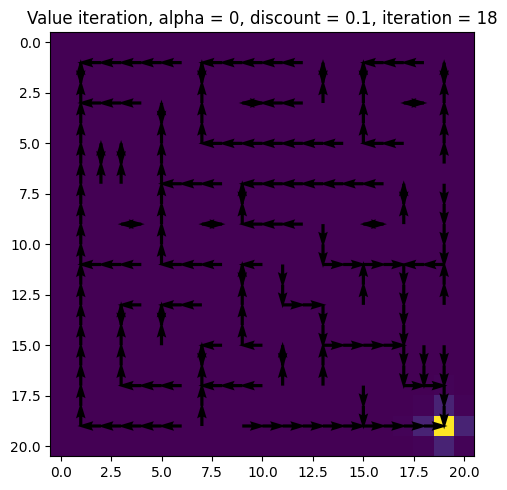

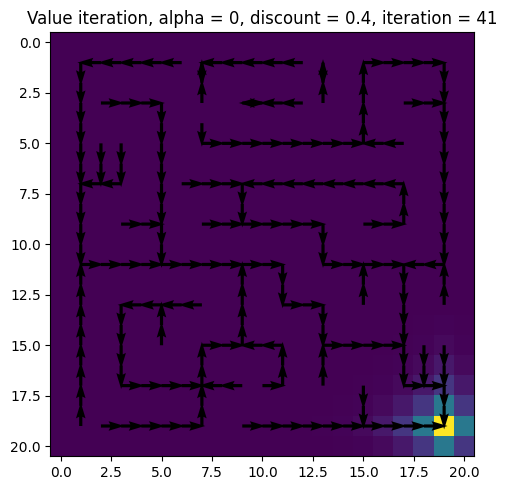

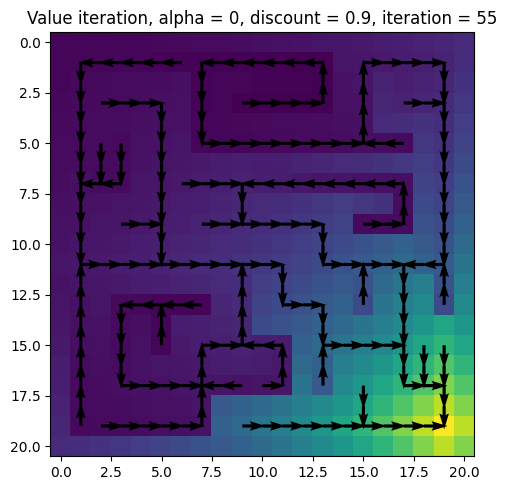

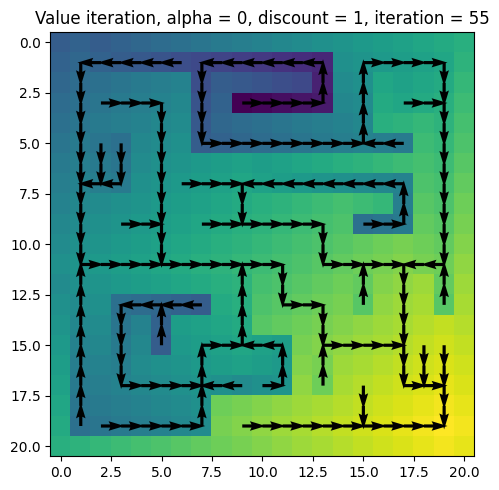

In [ ]:
DEF_Q3 = True
n_pol_eval = 100 #number of policy evalutions
val_time_list = []
for gamma in [0,0.1,0.4,0.9,1] :
    val1, pol1, val_max_iter, comp_time, normV = value_iteration(S, A, Pr, alpha=0, discount=gamma, plot_enable=True, plot=None)
    val_time_list.append(comp_time)
    plt.pause(0.1)
DEF_Q3 = False

#### Your explanations:


1. Explain the change in utilities for different $\gamma$
> * A higher value of gamma results in higher utilities for states that have higher long-term rewards. This is because a higher gamma places more emphasis on future rewards, which increases the value of states that lead to higher future rewards.

2. Explain the change in optimal policies for different $\gamma$
> * A higher value of gamma tends to favor policies that are more focused on long-term rewards, while a lower value of gamma tends to favor policies that are more focused on immediate rewards. 
> * A higher value of gamma tends to result in slower convergence but higher long-term rewards and low variance, while a lower value of gamma tends to result in faster convergence but lower long-term rewards and high variance. 
> * A lower value of gamma may not converge at all indicating the iteration was unable to find an optimal policy


### IV. Plot $\gamma$ VS computational time for the given $\gamma$ 's in Task 3:

#### 𝛾 VS computational time for Policy iteration :

Text(0.5, 1.0, 'Discount VS Computational time for Policy iteration')

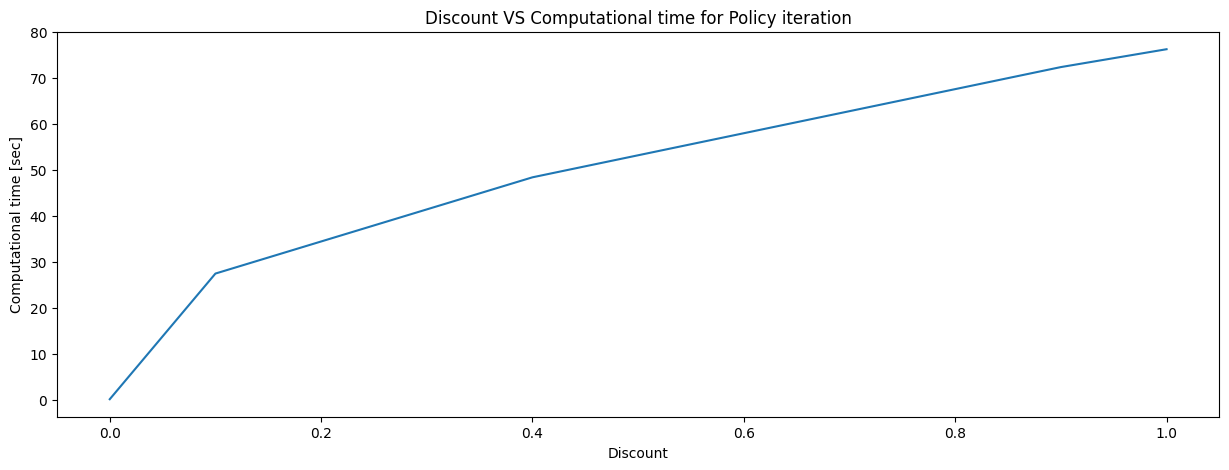

In [ ]:
fig = plt.figure(figsize=(15,5))

plt.xlabel('Discount')
plt.ylabel('Computational time [sec]')
plt.plot([0,0.1,0.4,0.9,1], pol_time_list)
plt.title('Discount VS Computational time for Policy iteration')

#### 𝛾 VS computational time for Value iteration :

Text(0.5, 1.0, 'Discount VS Computational time for Value iteration')

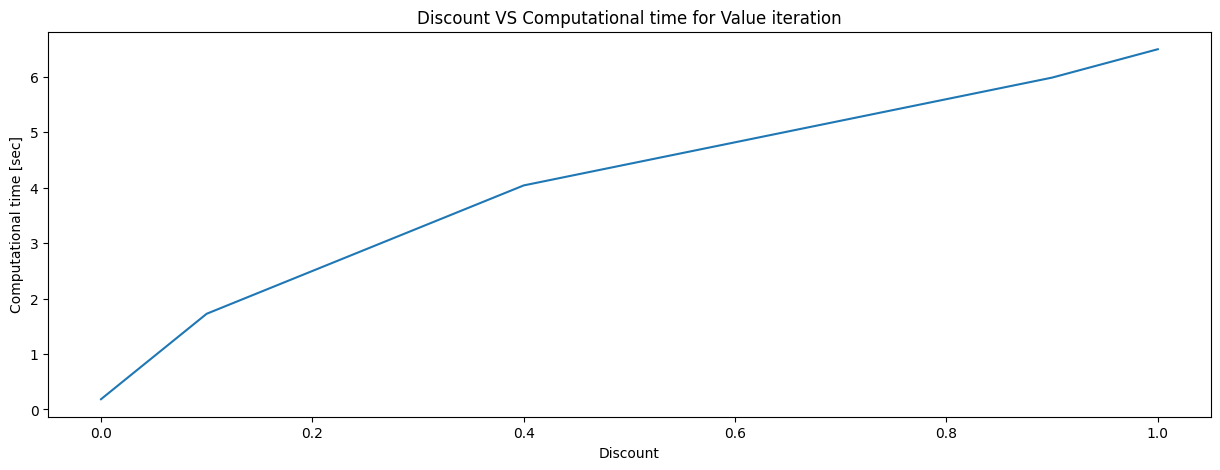

In [ ]:
fig = plt.figure(figsize=(15,5))

plt.xlabel('Discount')
plt.ylabel('Computational time [sec]')
plt.plot([0,0.1,0.4,0.9,1], val_time_list)
plt.title('Discount VS Computational time for Value iteration')

### V. Use five different discounted factors $\gamma \in \{0, 0.1, 0.4, 0.9, 1\}$ and preform the following tasks. Also, explain your insights.
1. Plot $V[s]$ as a function of the iteration number in "Policy Evaluation" for an arbitrary state, s, in the middle of your maze. Specifically, plot $V_{k}[s]$ vs $k$.  Here, the policy is constant, as it is being evaluated. 
2. Plot $V[s]$ as a function of the iteration number in "Policy Improvement" for the same state as in 1. above. 

Policy iteration failed to converge for alpha = 0, discount = 0.1, iteration = 101
Policy iteration failed to converge for alpha = 0, discount = 0.4, iteration = 101


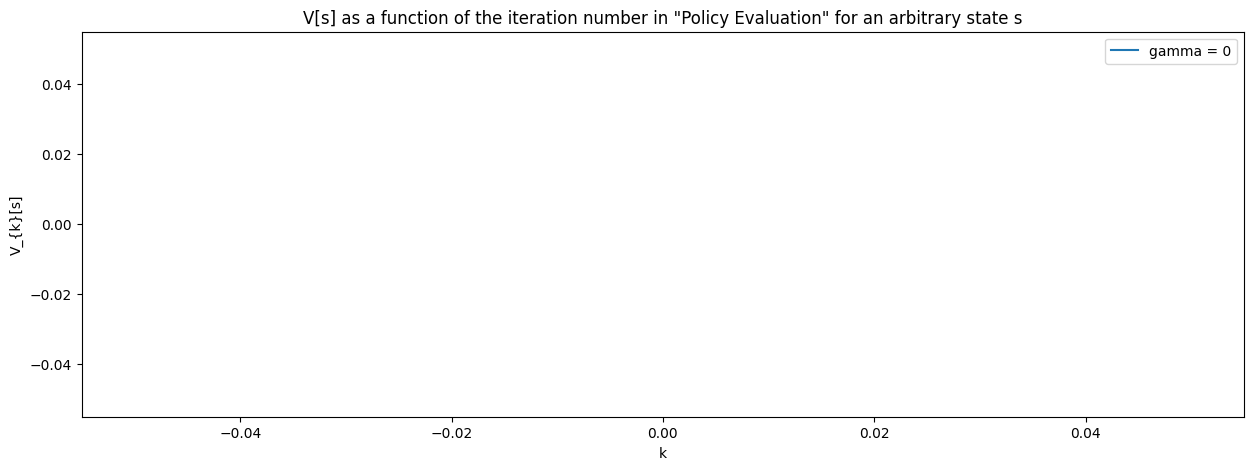

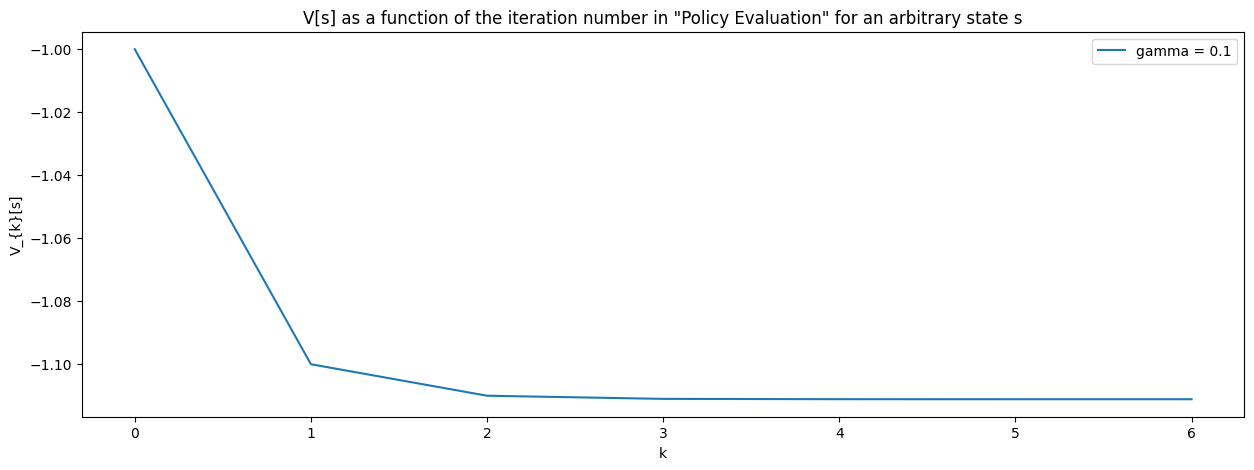

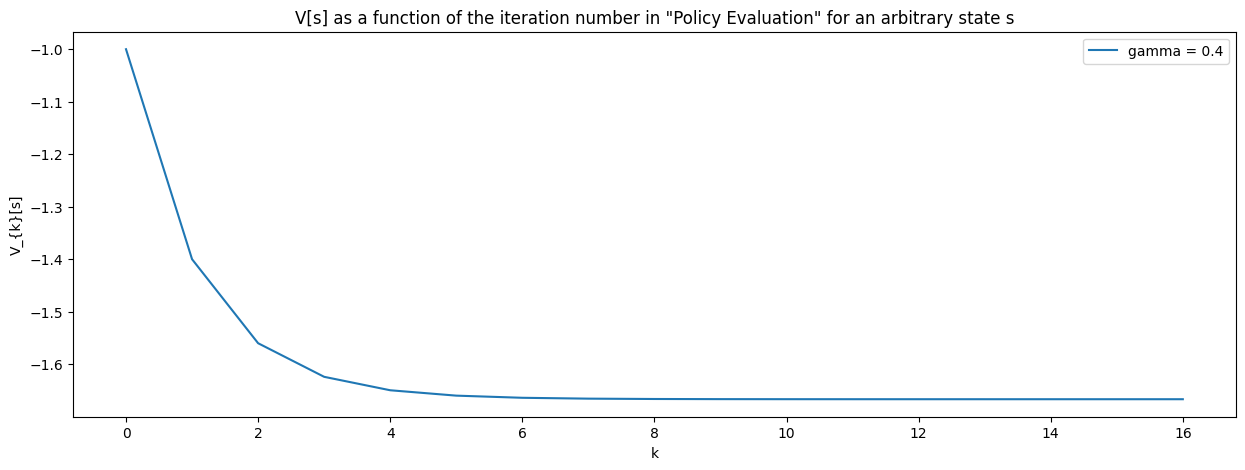

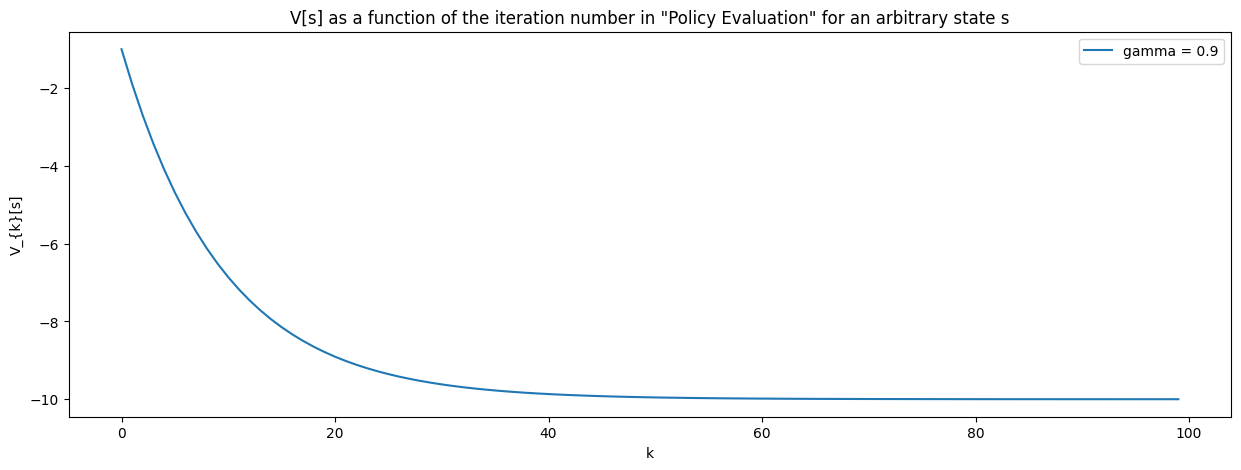

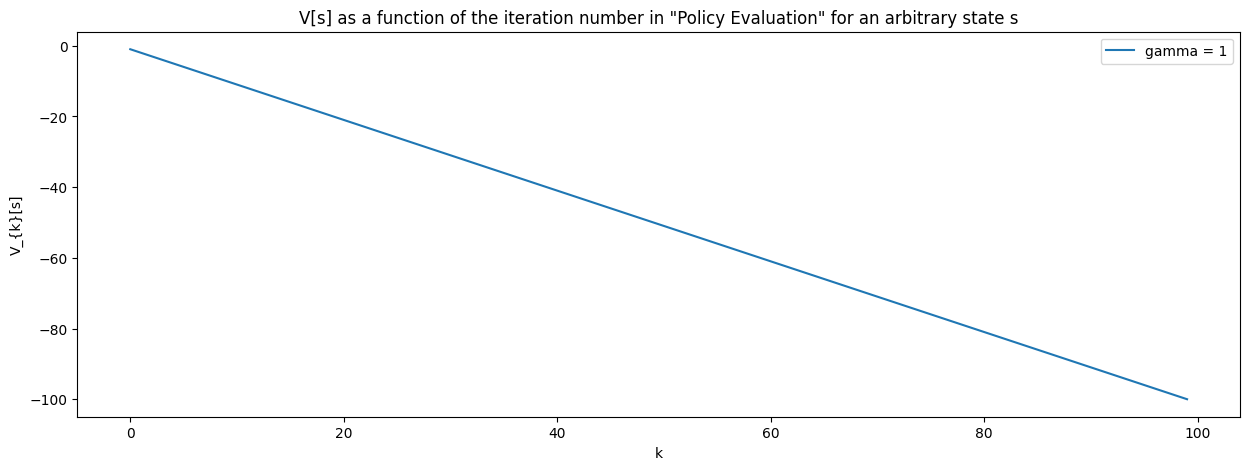

In [ ]:
DEF_Q5_1 = True

n_pol_eval = 100 #number of policy evalutions

for gamma in [0,0.1,0.4,0.9,1] : 
    
    fig = plt.figure(figsize=(15,5))
    plt.xlabel('k')
    plt.ylabel('V_{k}[s]')
    plt.title('V[s] as a function of the iteration number in "Policy Evaluation" for an arbitrary state s')

    val2, pol2, pol_max_iter, time_taken, normV, deltaV = policy_iteration(S, A, Pr, alpha=0, discount=gamma, theta = 1e-6, n_eval=n_pol_eval, plot_enable = False)

    plt.plot(range(len(V_ss1)), V_ss1, label = 'gamma = {}'.format(gamma))
    plt.legend()

DEF_Q5_1 = False

#### Your explanations:

For gamma = 0, the execution stops after 1 policy iteration. Hence value function is not plotted as a function of iterations.
As the value of gamma is increased, it takes more iterations for convergence. The value drop as a function of iterations. For higher values of gamma, the value drops gradually in a smoother fashion. For lower values of gamma, the value drops rapidly with each iteration.

Policy iteration failed to converge for alpha = 0, discount = 0.1, iteration = 101
Policy iteration failed to converge for alpha = 0, discount = 0.4, iteration = 101


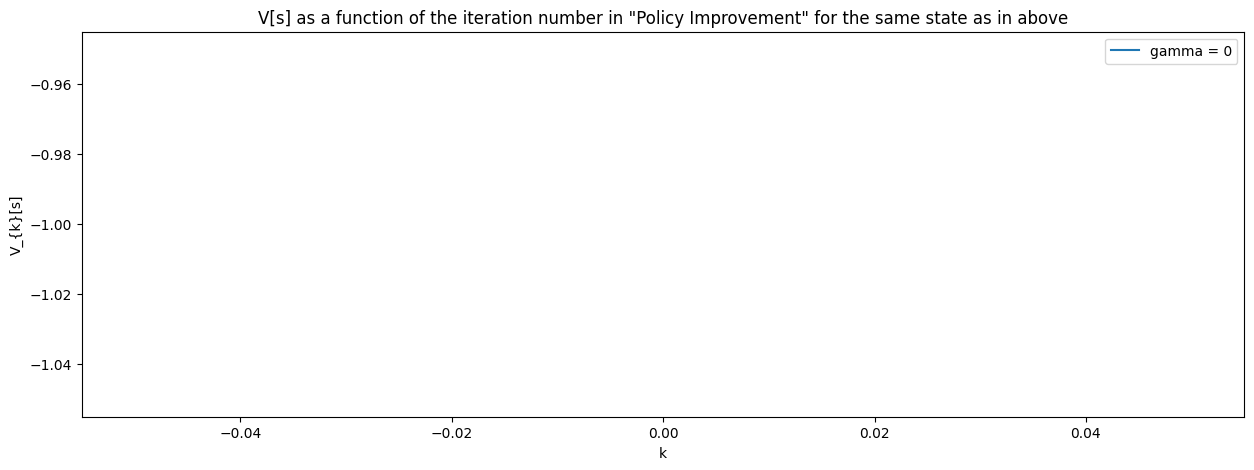

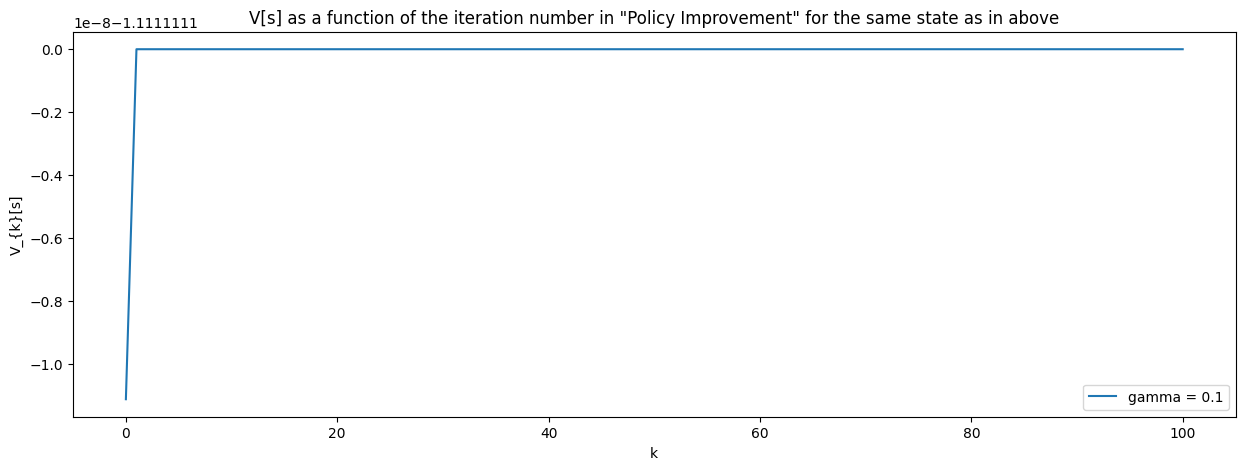

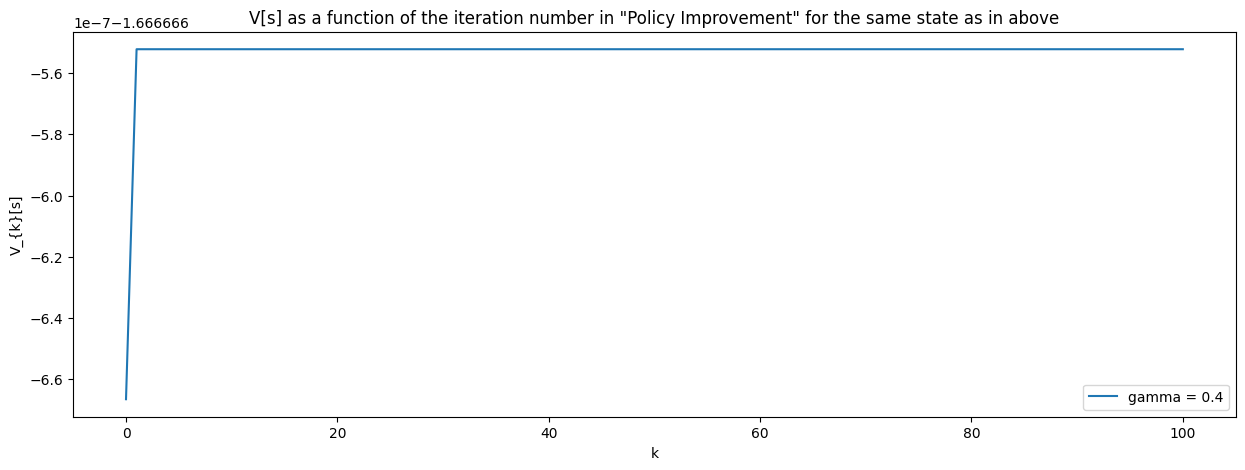

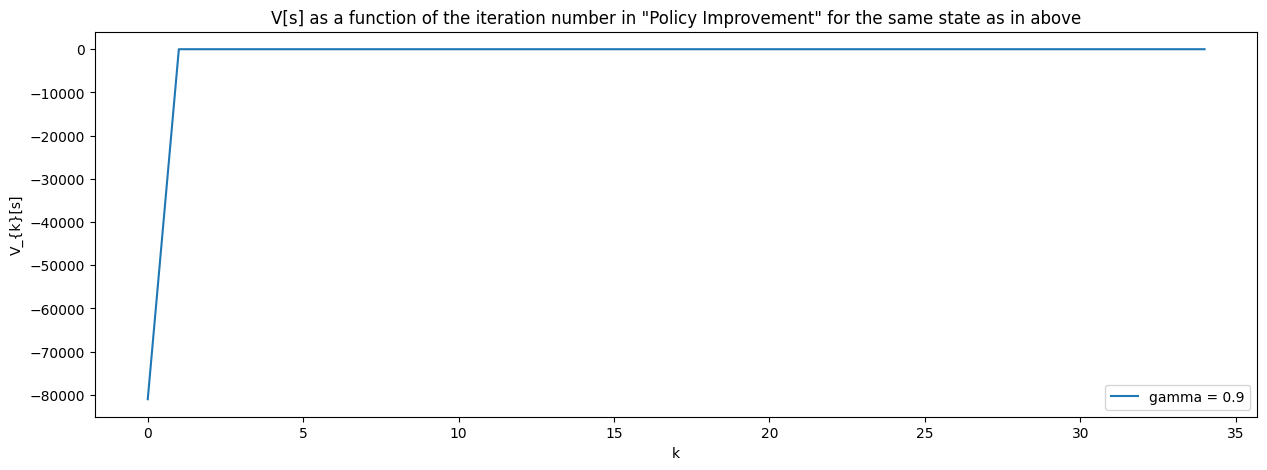

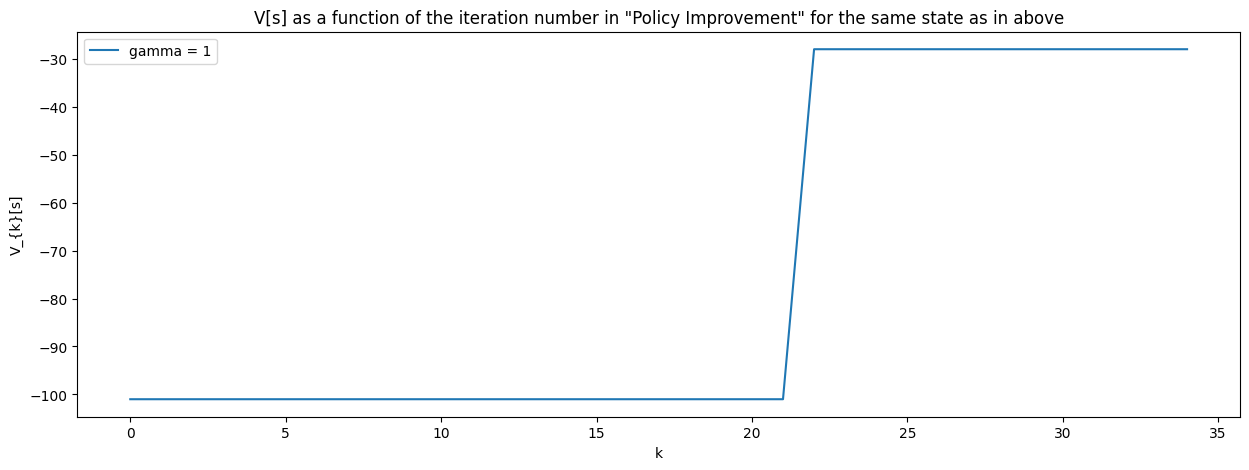

In [ ]:
DEF_Q5_2 = True

n_pol_eval = 100 #number of policy evalutions

for gamma in [0,0.1,0.4,0.9,1] : 
    
    fig = plt.figure(figsize=(15,5))
    plt.xlabel('k')
    plt.ylabel('V_{k}[s]')
    plt.title('V[s] as a function of the iteration number in "Policy Improvement" for the same state as in above')
    
    val2, pol2, pol_max_iter, time_taken, normV, deltaV = policy_iteration(S, A, Pr, alpha=0, discount=gamma, theta = 1e-6, n_eval=n_pol_eval, plot_enable = False)
    
    plt.plot(range(len(V_ss2)), V_ss2, label = 'gamma = {}'.format(gamma))
    plt.legend()

DEF_Q5_2 = False

#### Your explanations:

The graphs above show how quickly optimality of policy is found with repect to the gamma value. A higher value of gamma tends to take longer to find the optimality of policy, whereasm a lower value of gamma tends to find optimality of policy much quicker.

A higher value of gamma tends to result in slower convergence but higher long-term rewards and low variance, while a lower value of gamma tends to result in faster convergence but lower long-term rewards and high variance.

### VI. plot norm(V_{k+1} - V_k) as a function of k, and explain your observations.
 where k is the iteration in which it converges 

#### $norm(V_{k+1} - V_k)$ VS $k$ for Policy iteration :

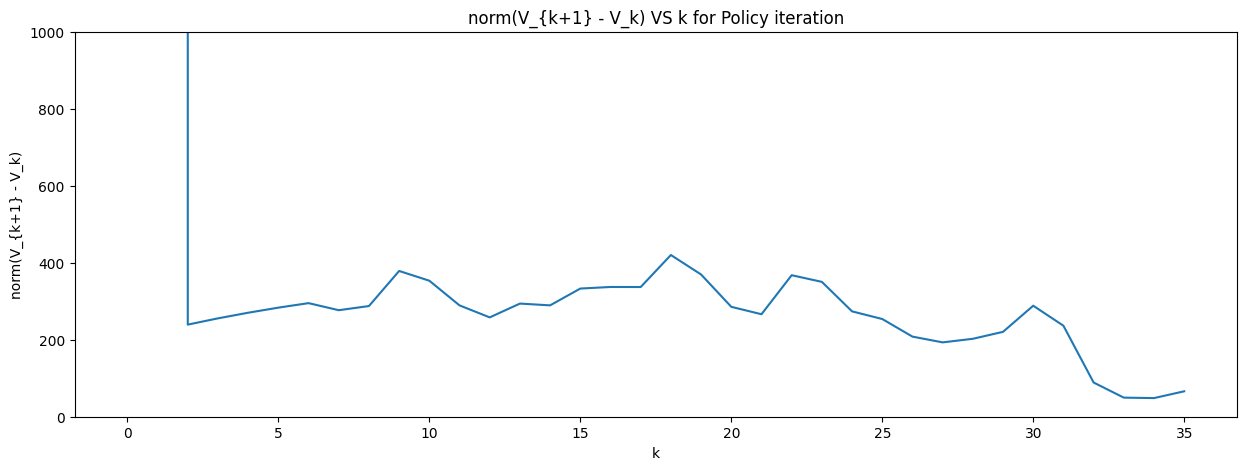

In [ ]:
DEF_Q6 = True
n_pol_eval = 100 #number of policy evalutions
val2, pol2, pol_max_iter, time_taken, normV, deltaV = policy_iteration(S, A, Pr, alpha=0, discount=1, theta=1e-6, n_eval=n_pol_eval, plot_enable = False)
#print(normV)
fig = plt.figure(figsize=(15,5))

plt.xlabel('k')
plt.ylabel('norm(V_{k+1} - V_k)')
plt.ylim([0, 1000])
plt.plot(range(len(normV)), normV)
plt.title('norm(V_{k+1} - V_k) VS k for Policy iteration')
DEF_Q6 = False


#### $norm(V_{k+1} - V_k)$ VS $k$ for Value iteration :

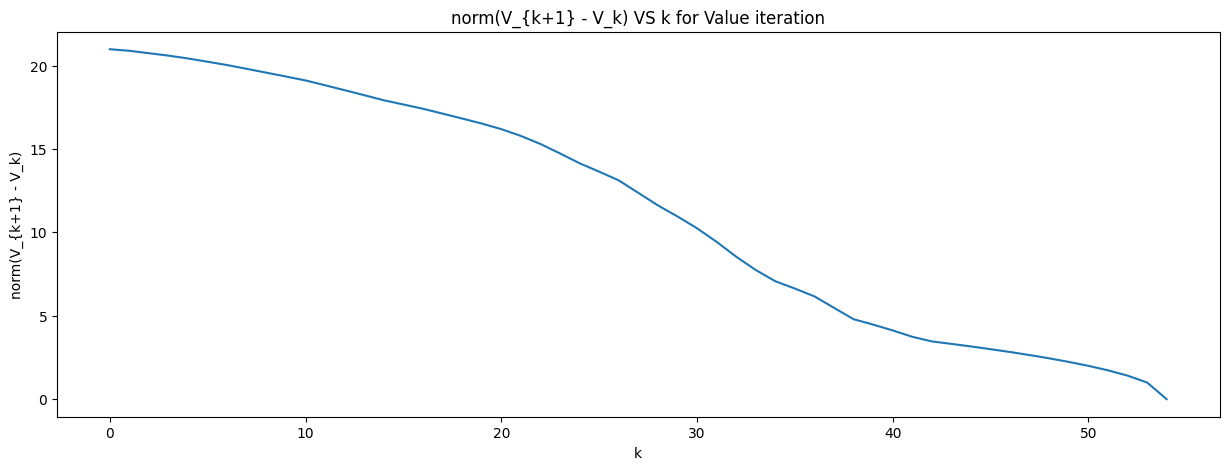

In [ ]:
DEF_Q6 = True
val1, pol1, val_max_iter, time_taken, normV = value_iteration(S, A, Pr, alpha=0, discount=1, plot_enable=False, plot=None)
#print(normV)
fig = plt.figure(figsize=(15,5))

plt.xlabel('k')
plt.ylabel('norm(V_{k+1} - V_k)')
plt.plot(range(len(normV)), normV)
plt.title('norm(V_{k+1} - V_k) VS k for Value iteration')
DEF_Q6 = False


#### Your explanations:

For policy iteration with gamma = 1, the initial norm is high as the initial policy is random. As the policy is improved the norm varies untill it reaches its lowest value at the last iteration when convergence happens.

For value iteration with gamma = 1, convergence takes 55 iterations which is when the optimal value matrix is evaluated. Since the change is value over each iterations is small, the norm follows a gradual curve to convergence.

### VII. Calculate the delta in iteration of the policy iteration for different theta and gamma. Plot them and also Explain your understanding

Policy iteration failed to converge for alpha = 0, discount = 0.4, iteration = 101
Policy iteration failed to converge for alpha = 0, discount = 0.7, iteration = 101


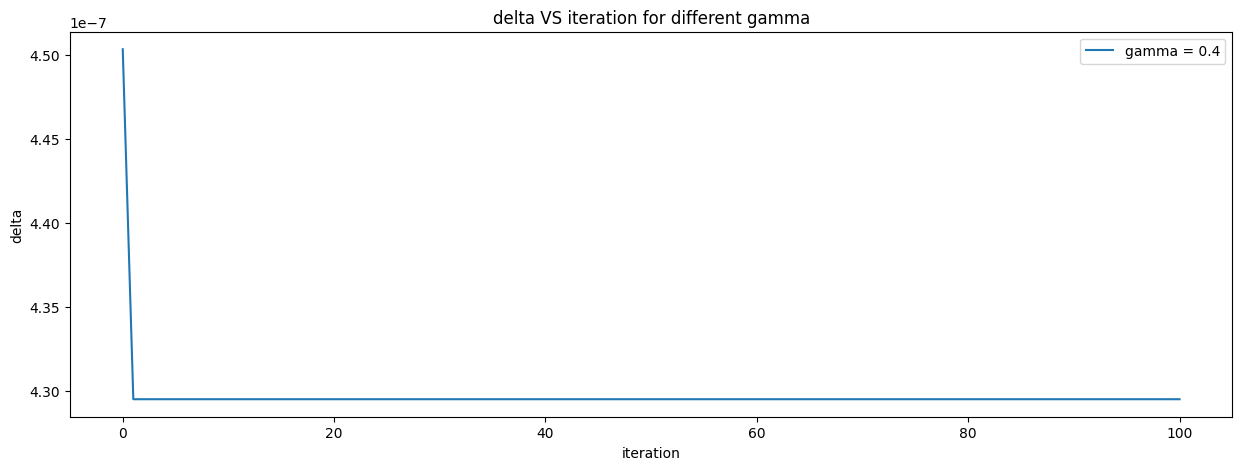

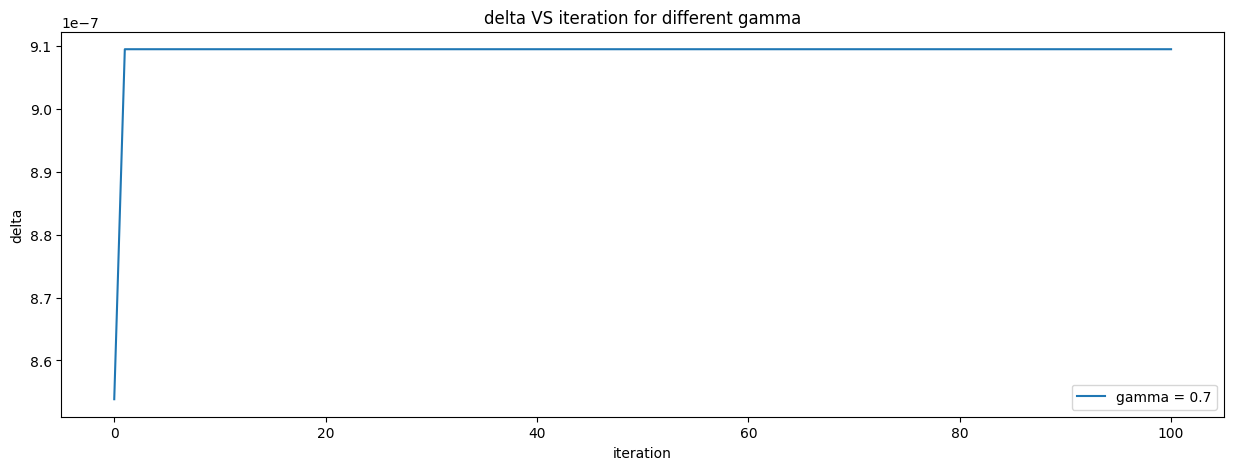

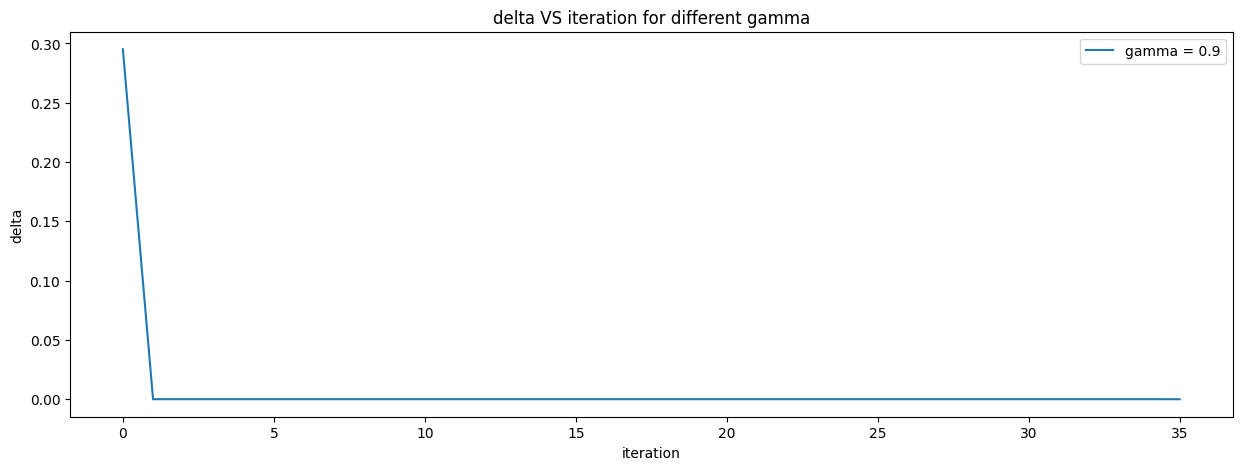

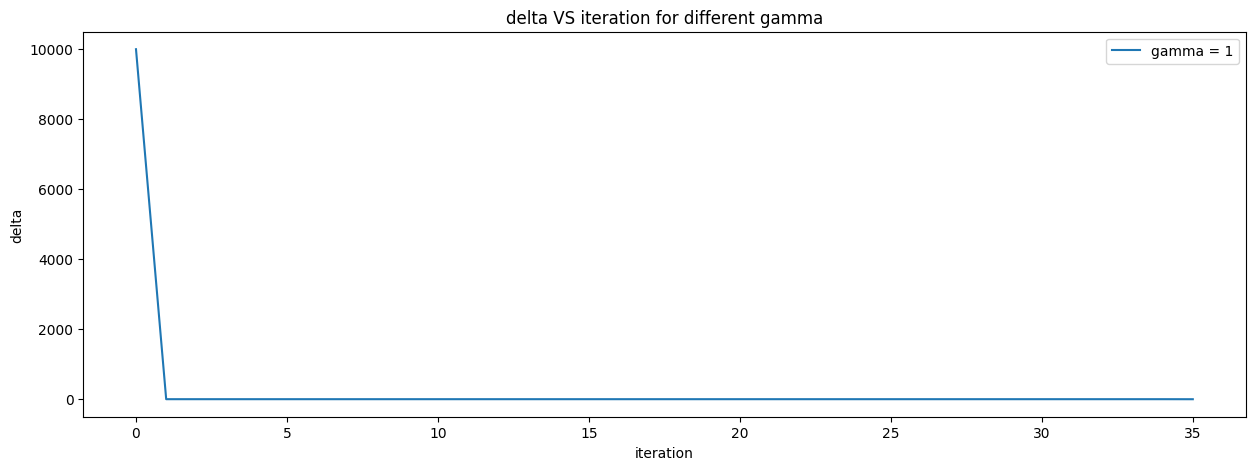

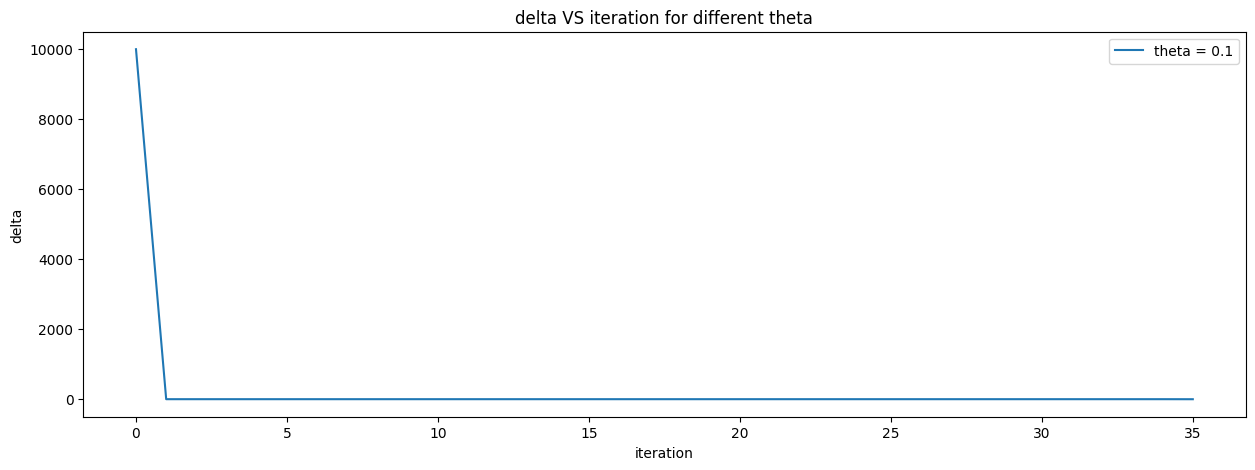

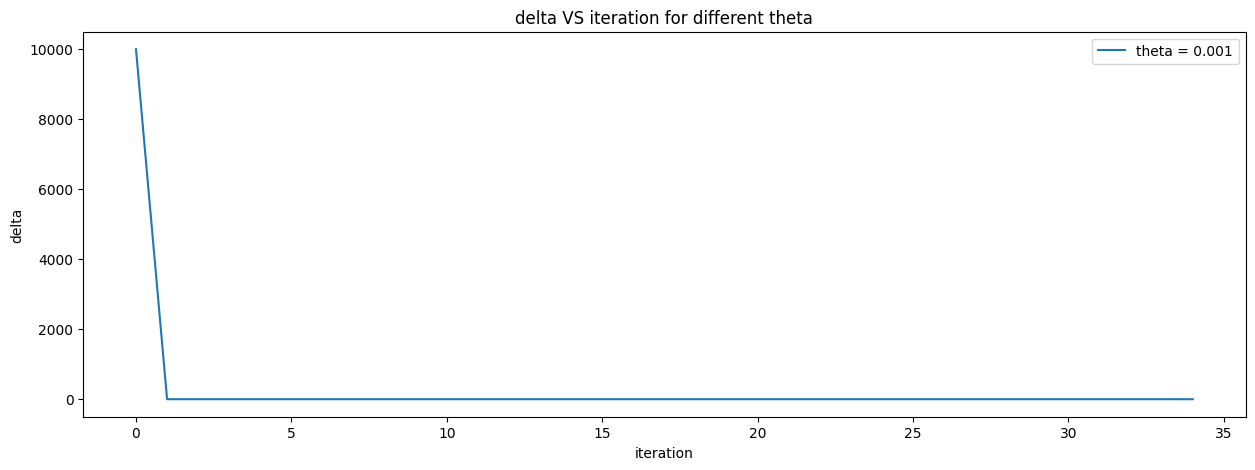

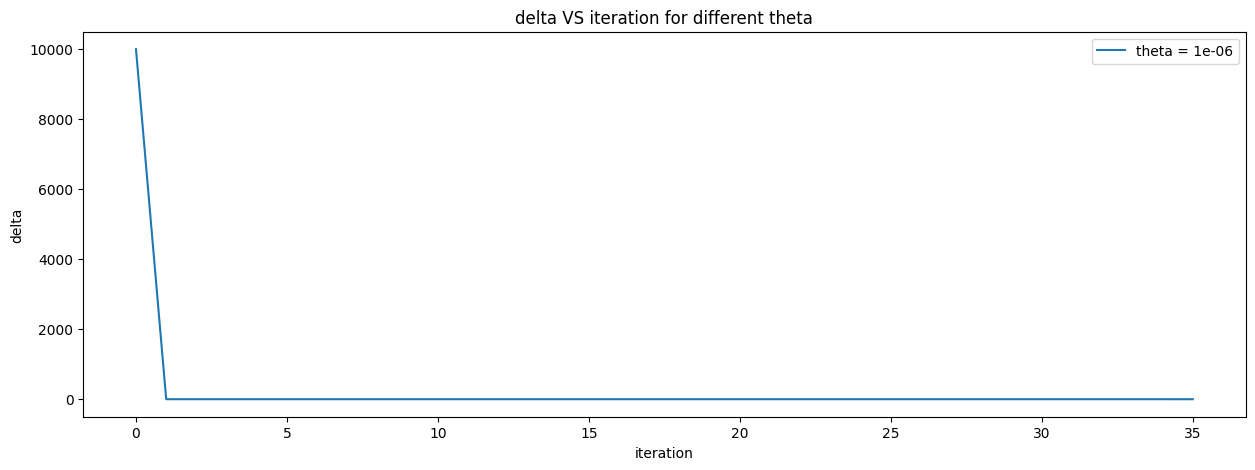

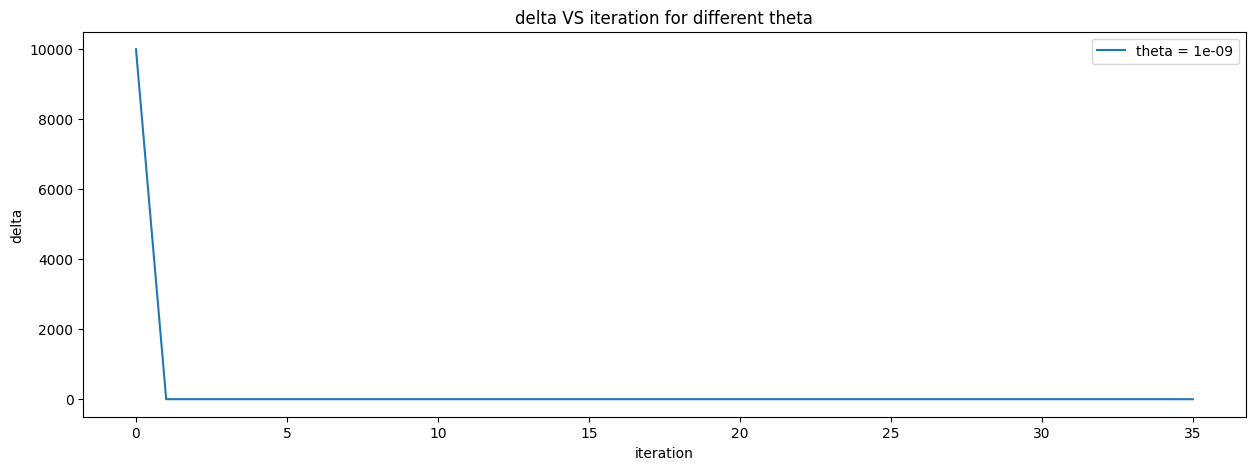

In [ ]:
DEF_Q7 = True
n_pol_eval = 100 #number of policy evalutions


for gamma in [0.4,0.7,0.9,1] :  
    fig = plt.figure(figsize=(15,5))
    plt.xlabel('iteration')
    plt.ylabel('delta')
    plt.title('delta VS iteration for different gamma')
    #plt.ylim([0, 1e-3])
    val2, pol2, pol_max_iter, comp_time, normV, deltaV = policy_iteration(S, A, Pr, alpha=0, discount=gamma, theta=1e-6, n_eval=n_pol_eval, plot_enable=False, plot = None)
    plt.plot(range(len(deltaV)), deltaV, label = 'gamma = {}'.format(gamma))
    #print('*** For gamma = {}, delta = {} '.format(gamma, deltaV))
    plt.legend()
    

for theta in [1e-1, 1e-3, 1e-6, 1e-9] :  
    fig = plt.figure(figsize=(15,5))
    plt.xlabel('iteration')
    plt.ylabel('delta')
    plt.title('delta VS iteration for different theta')
    val2, pol2, pol_max_iter, comp_time, normV, deltaV = policy_iteration(S, A, Pr, alpha=0, discount=1, theta=theta, n_eval=n_pol_eval, plot_enable=False, plot = None)
    plt.plot(range(len(deltaV)), deltaV, label = 'theta = {}'.format(theta))
    #print('*** For theta = {}, delta = {} '.format(theta, deltaV))
    plt.legend()

plt.show() 
    
DEF_Q7 = False
    


#### Your explanations:

For most different values of gamma and theta, delta starts from a higher value and stabilises quickly to a lower value within the first few iterations.
It is observed that delta for gamma = 0.7 follows an opposite trend. It start from a lower value and stabilises quickly within the first few iteration to a higher value. 

### B. Repeat Value and Policy iteration for 10, 20 and 100 iterations with $\alpha \in \{0.2, 0.8\}$

#### I. Policy Iteration 

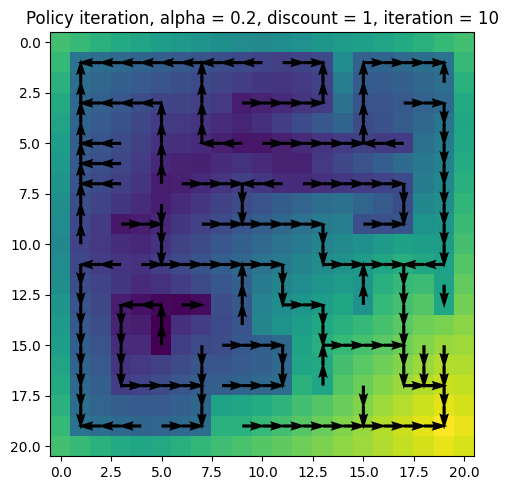

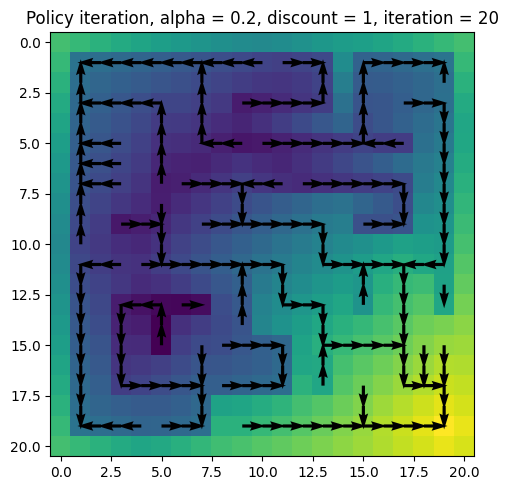

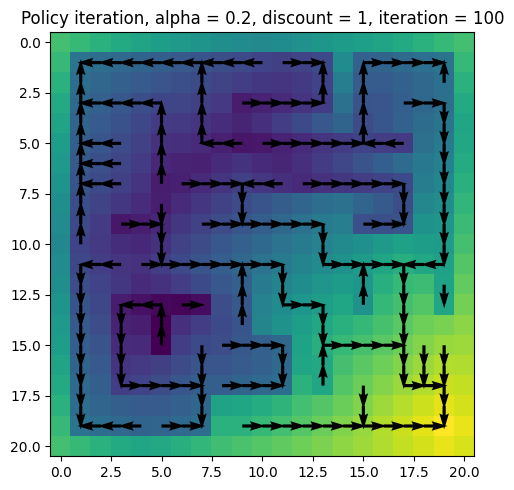

Policy iteration failed to converge for alpha = 0.2, discount = 1, iteration = 101


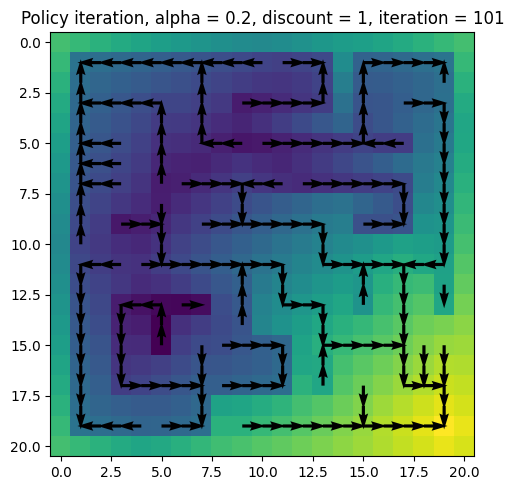

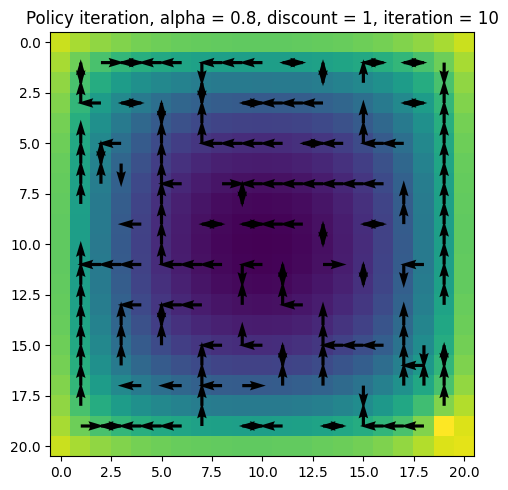

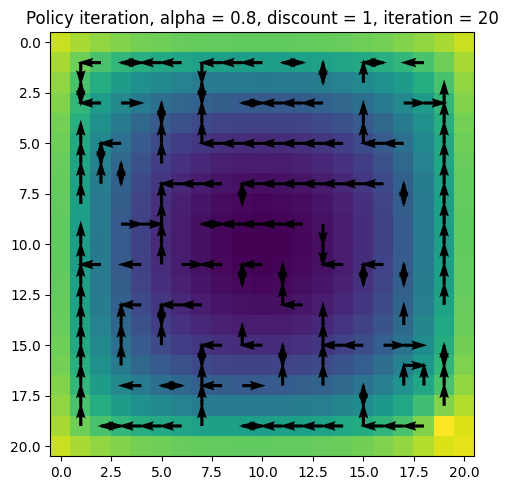

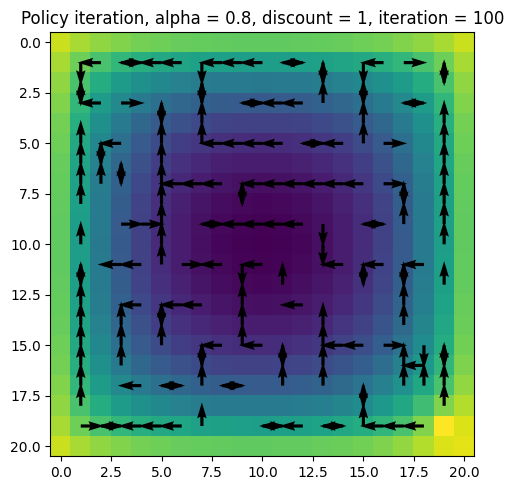

Policy iteration failed to converge for alpha = 0.8, discount = 1, iteration = 101


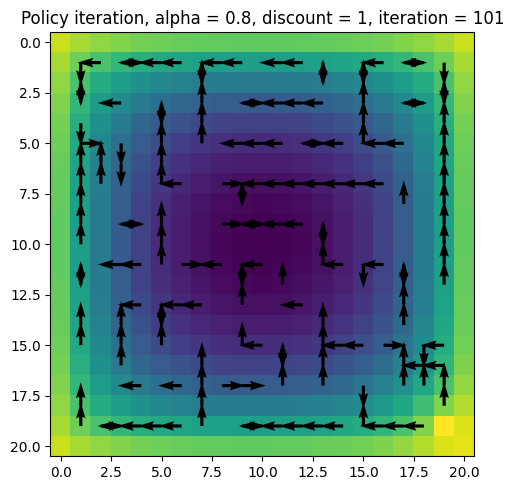

In [ ]:
for idx1, alpha in enumerate(ALPHA):
    val, pol, pol_iter, time_taken, normV, deltaV = policy_iteration(S, A, Pr, alpha=alpha, discount = 1, theta=1e-6, n_eval=100, plot_enable = True, plot=[10, 20, 100])
    

#### II. Value Iteration

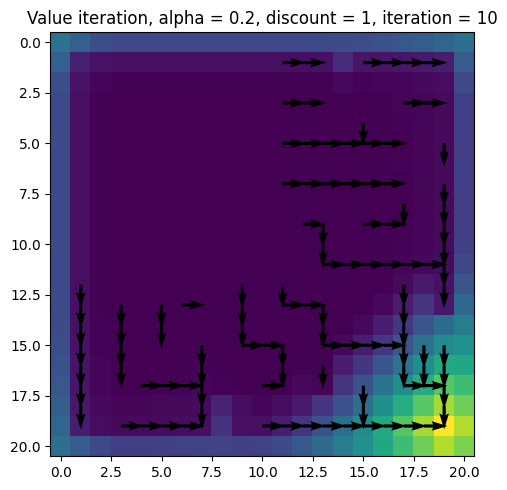

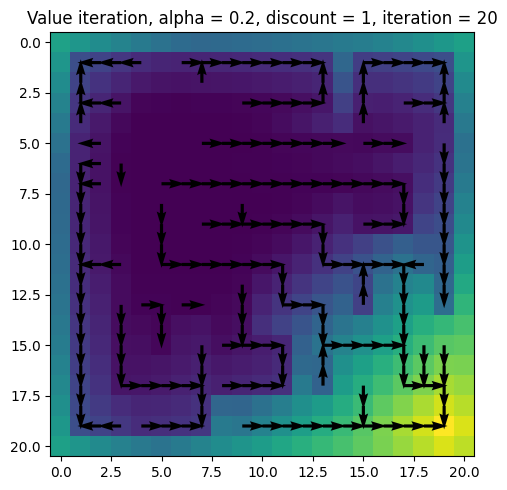

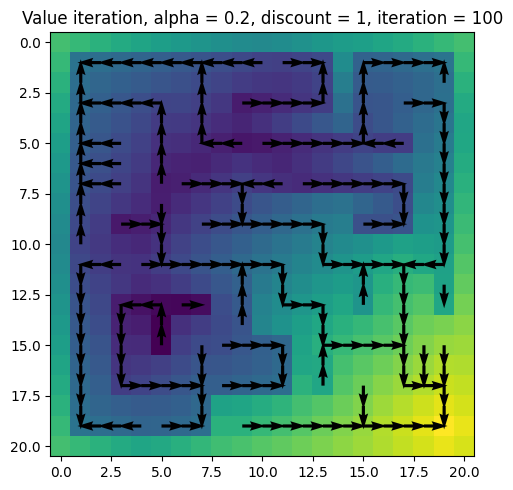

Value iteration failed to converge for alpha = 0.2, discount = 1, iteration = 101


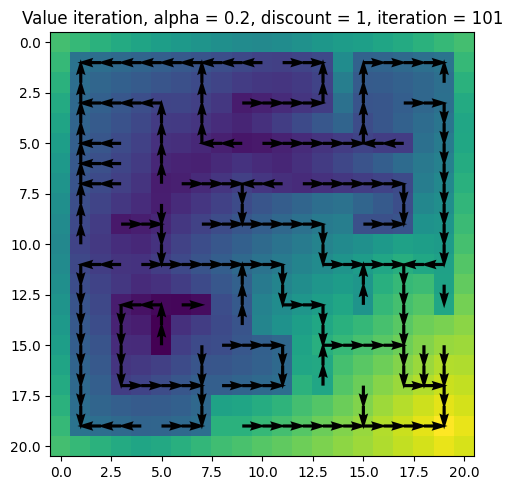

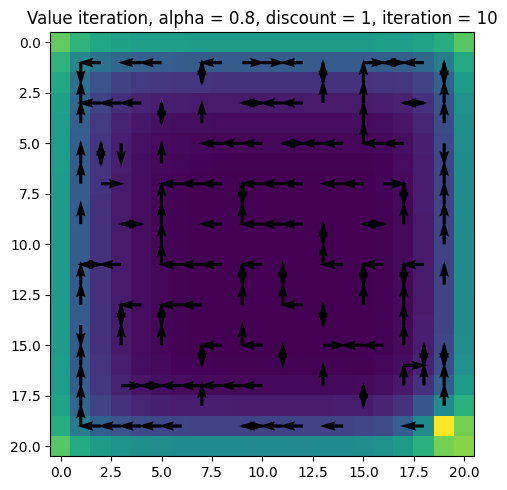

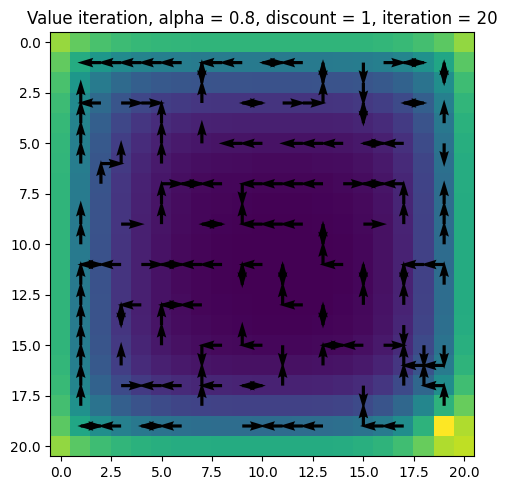

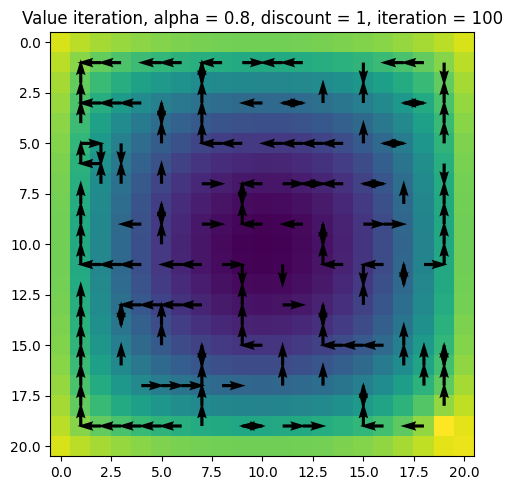

Value iteration failed to converge for alpha = 0.8, discount = 1, iteration = 101


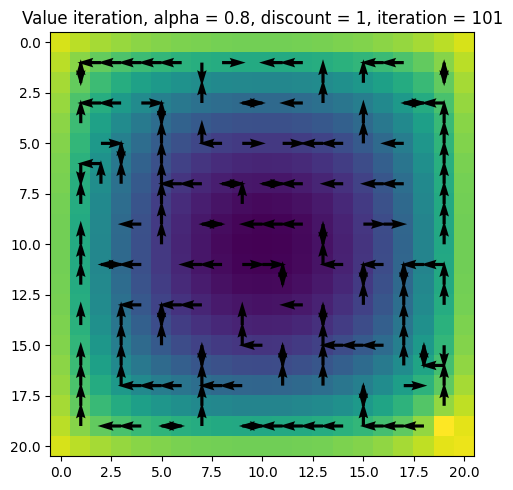

In [ ]:
for idx1, alpha in enumerate(ALPHA):
    val, pol, val_iter, comp_time, normV = value_iteration(S, A, Pr, alpha = alpha, discount = 1, plot_enable=True, plot=[10, 20, 100])
    

**Summarize insights and your observations in Question 1 & 2 .** 

It is observed that the policy iteration does not converge either for lower value(0.8) or higher value(0.8). This is because a randomness is introduced in the agent executing the action given by policy. Thus, the agent may not follow the action given by policy even if it is the optimal action at that time. This randomness affects policy improvement and an optimal policy is not reached.

The value iteration also fails to converge for both values of alpha. Since the action given by the policy may not be executed by the agent, the evaluation of value has a randomness too.

### C. Explain (up to 5 sentences) the differences between the approaches in HW1 (search, A*) and the approaches in the current assignment (MDP/Value/Policy) 

*   In HW1, we used uninformed search and informed search methods to solve the maze. In HW3, we are using Markov Decision Process to solve the maze.
*   In HW1, we learned how informed(heuristic based) search is better than uninformed search methods. In HW3 we are learning how the policy iteration and value iteration works. We also learn how different parameters affect the learning rate and convergence.
*   In the search methods, no learning by the agent is happening. In MDP using policy and value iterations, optimal action for every state is learned.
*   A* search is used only to find the shortest path in a graph, MDP along with value and policy can be applied to a wide variety of problems to find optimal value/action/etc.
*   A* search might not work in domains where there is a lot of uncertainity. On the other hand, MDP is designed to operate in on-deterministic areas. Uncertainity is inherently factored into MDP's mathematical framework.